In [3]:
import sys
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import math

# Adjust the path for c2qa and bosonic-qiskit modules
module_path = os.path.abspath(os.path.join('..', '..', '..'))  # Moves three directories up
if module_path not in sys.path:
    sys.path.append(module_path)

# Add the `playground` directory to the Python path
playground_path = Path.cwd().parent.parent  # Move two levels up to `playground`
if str(playground_path) not in sys.path:
    sys.path.append(str(playground_path))


# Qiskit and related imports
import qiskit
from qiskit.quantum_info import state_fidelity, Statevector, SparsePauliOp, Operator, Clifford
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate, UnitaryGate
from qiskit.synthesis import LieTrotter, SuzukiTrotter
import qutip as qt
from qiskit import transpile


# Project-specific imports
import c2qa
import c2qa.util as util



This notebook looks at implementing the 1D Holstein model using hybrid qubit-qumode architechture (see [Sec II.3 here](https://arxiv.org/pdf/2307.06580)). 
The one-dimensional version of the Holstein model reads

$$
\hat{H} = - \sum_{\langle i, j \rangle} V f^\dagger_i f_j + \sum_i \omega b^\dagger_i b_i + \sum_i g \omega f^\dagger_i f_i (b^\dagger_i + b_i),
$$

with $V$ the hopping coefficient between the nearest neighbour pair $\langle i, j \rangle$, $\omega$ the vibration frequency, and $g$ the coupling constant. For simplicity, we will first choose a two-site Holstein model with periodic boundary conditions:
$$
\begin{aligned}
\hat{H} &= -V \Bigl( f^\dagger_1 f_2 + f^\dagger_2 f_1 \Bigr) \\
&\quad + \omega \Bigl( b^\dagger_1 b_1 + b^\dagger_2 b_2 \Bigr) \\
&\quad + g\,\omega \Bigl[ f^\dagger_1 f_1 \left( b^\dagger_1 + b_1 \right) + f^\dagger_2 f_2 \left( b^\dagger_2 + b_2 \right) \Bigr].
\end{aligned}
$$
We first note that in this architechture, for e.g. the first term, we will need oscillator-mediated multi-qubit gates, however, for now, we ignore this requirement.

Using a Jordan-Wigner mapping, the first term $ -V \Bigl( f^\dagger_1 f_2 + f^\dagger_2 f_1 \Bigr) = -V/2(X_1X_2 + Y_1Y_2)$ corresponds to an fSim gate. We define this first below.
The $\omega \Bigl( b^\dagger_1 b_1 + b^\dagger_2 b_2 \Bigr)$ term can be implemented at each site individually using a phase space rotation gate $\text{exp}(-i\theta n_i)$, with $\theta = \omega$. Finally, the boson-fermion coupling term $f^\dagger_1 f_1 \left( b^\dagger_1 + b_1 \right) = (Z_1 + 1)(b_1^{\dagger} + b_1)$, which is easy to implement as all terms in the sum commute and each
has a simple implementation; the term proportional to $Z_1$ generates a conditional displacement gate and the remaining term is a dispacement.


In [4]:
def hopping_term(theta):
    """
    Create an fSim gate defined as U(t)=exp(i Vt/2 (XX+YY)).
    """
    
    U = np.array([
        [1,               0,               0, 0],
        [0,  np.cos(theta), -1j * np.sin(theta), 0],
        [0, -1j * np.sin(theta),  np.cos(theta), 0],
        [0,               0,               0, 1]
    ])
    return UnitaryGate(U, label="fSim")


Below, we create the (noiseless) circuit for Trotterization between two sites, which returns a statevector. We also create a function to compute the fermion & boson occupations of this statevector. A quick note about displacements: bosonic qiskit defines $D(\alpha) = \text{exp}(\alpha a^\dagger- \alpha^* a)$. So, to implement $ \text{exp}(-i\phi(a^\dagger + a))$, we need to choose $D(-i\phi)$. The same is true for conditional displacements.


In [ ]:
def create_quantum_circuit(num_sites, num_qubits_per_qumode, fermion_init):
    """Create and initialize the circuit"""
    # Create registers
    qmr = c2qa.QumodeRegister(num_qumodes=num_sites, 
                             num_qubits_per_qumode=num_qubits_per_qumode)
    qbr = qiskit.QuantumRegister(num_sites)
    circuit = c2qa.CVCircuit(qmr, qbr)
    
    # Initialize fermions
    fermion_state = list(fermion_init)
    if len(fermion_state) != 2**num_sites:
        raise ValueError(f"Fermionic state vector must have length 2**(num_sites) = {2**num_sites}")
    circuit.initialize(fermion_state, qbr)
    
    return circuit, qmr, qbr

def apply_trotter_steps(circuit, qmr, qbr, num_trotter, dt, v, omega, g, noise):
    """Apply the Trotter decomposition"""
    cv_c_d_gatetime = 10 #in ns
    for step in range(num_trotter):
        # Hopping term
        fsim_gate = hopping_term(-v * dt)
        circuit.append(fsim_gate, [qbr[0], qbr[1]])
        
        # onsite boson potential
        circuit.cv_r(-omega * dt, qmr[0])
        circuit.cv_r(-omega * dt, qmr[1])
        
        # Coupling term
        circuit.cv_c_d(-1j * (g * omega / 2) * dt, qmr[0], qbr[0], duration=cv_c_d_gatetime if noise else None, unit="ns" if noise else None) #noisy cd
        circuit.cv_d(-1j * (g * omega / 2) * dt, qmr[0])
        circuit.cv_c_d(-1j * (g * omega / 2) * dt, qmr[1], qbr[1], duration=cv_c_d_gatetime if noise else None, unit="ns" if noise else None)
        circuit.cv_d(-1j * (g * omega / 2) * dt, qmr[1])
    
    return circuit

def run_simulation(circuit, noise=False, shots=10):
    """Run with or without noise."""
    if noise:
        photon_loss_rate = 1e-5 #in 1/ns
        # Add photon loss noise
        noise_pass = c2qa.kraus.PhotonLossNoisePass(
            photon_loss_rates=photon_loss_rate, circuit=circuit, time_unit="ns"
        )
        # Run  with noise
        states, _, _ = c2qa.util.simulate(
            circuit, shots=shots, per_shot_state_vector=True,
            return_fockcounts=False, noise_passes=noise_pass
        )
        # states will be a list of state vectors, one for each shot
        return states, True  # a flag indicating it's a list
    else:
        # Run the simulation without noise
        state, _, _ = c2qa.util.simulate(circuit)
        return state, False  # flag indicating it's not a list

def process_state(state_data, num_qubits_per_qumode):
    """
    Converts qiskit statevector(s) into a qutip Qobj 
    for easier comparisons
    """
    state, is_list = state_data
    
    # Function for a single statevector
    def process_single_state(single_state):
        dims = [[2, 2, 2**num_qubits_per_qumode, 2**num_qubits_per_qumode], [1, 1, 1, 1]]
        state_qobj = qt.Qobj(single_state, dims=dims)
        
        d_b = 2**num_qubits_per_qumode
        S_bos = 0
        for i in range(d_b):
            for j in range(d_b):
                ket = qt.tensor(qt.basis(d_b, j), qt.basis(d_b, i))
                bra = qt.tensor(qt.basis(d_b, i), qt.basis(d_b, j)).dag()
                S_bos += ket * bra
        
        I_ferm = qt.tensor(qt.qeye(2), qt.qeye(2))
        P = qt.tensor(I_ferm, S_bos)
        return P * state_qobj
    
    # If we have a list of states, process each one
    if is_list:
        return [process_single_state(s) for s in state]
    else:
        return process_single_state(state)

def simulate_holstein_model(dt, num_trotter, v, omega, g, fermion_init, num_qubits_per_qumode, noise=False, shots=10):
    """
    Simulate the two-site Holstein model using a Trotter decomposition.
    Returns:
    state_qobj : Qobj or list of Qobj
        The final quantum state(s) as a Qobj or list of Qobjs
    circuit : ?
        The quantum circuit 
    """
    num_sites = 2
    
    # Create and initialize the circuit
    circuit, qmr, qbr = create_quantum_circuit(num_sites, num_qubits_per_qumode, fermion_init)
    
    # Apply Trotter steps
    circuit = apply_trotter_steps(circuit, qmr, qbr, num_trotter, dt, v, omega, g, noise=noise)
    
    # Run the simulation
    state_data = run_simulation(circuit, noise, shots)
    
    # Process the state(s)
    state_qobj = process_state(state_data, num_qubits_per_qumode)
    
    return state_qobj, circuit

So for $N=2$, the Trotter step requires a total of 7 gates: 1 two-qubit gate for the hopping term, 2 mode rotations (one per site), 2 displacements, and 2 conditional displacements. For a 1D system with $N>2$ sites under periodic boundary conditions, the hopping term is implemented with $N$ two-qubit gates (one for each unique nearest-neighbor pair), while the on-site terms scale as $N$ mode rotations, $N$ displacements, and $N$ conditional displacements. Thus, the overall gate count per Trotter step scales as $N$ two-qubit gates plus $N$ mode rotations plus $N$ displacements plus $N$ conditional displacements (a total of $4N$ gates). We'll also just need $N$ qubits and $N$ modes. **NOTE this is without considering the use of oscillator mediated gates.**

We can then compare this to the "exact" dynamics by using qutips master equation solver `mesolve`. 

In [29]:
def exact_qutip_holstein_sim(v=1.0, omega=1.0, g=1.0, N_b=8,
                             t_max=5, num_steps=100,
                             fermion_init= [1, 0 , 0 ,0]):
    """
    Perform an exact simulation of the two-site Holstein model using qutip’s mesolve.
    """
    times_exact = np.linspace(0, t_max, num_steps)
    
    # fermion initialization
    fermion_state = np.array(fermion_init, dtype=complex)
    if fermion_state.size != 4:
        raise ValueError("Fermionic state vector must have 4 elements")
    psi_f = qt.Qobj(fermion_state, dims=[[2, 2], [1, 1]])
    
    # boson initialization
    psi_b1 = qt.basis(N_b, 0)
    psi_b2 = qt.basis(N_b, 0)
    
    psi0_exact = qt.tensor(psi_f, psi_b2, psi_b1) # to match qiskit order
    
    # build Hamiltonian 
    I_2 = qt.qeye(2)
    f1 = qt.tensor(qt.destroy(2), I_2)
    f2 = qt.tensor(qt.sigmaz(), qt.destroy(2))
    n1 = f1.dag() * f1
    n2 = f2.dag() * f2
    
    I_b = qt.qeye(N_b)
    b1 = qt.destroy(N_b)
    b2 = qt.destroy(N_b)
    
    f1_tot = qt.tensor(f1, I_b, I_b)
    f2_tot = qt.tensor(f2, I_b, I_b)
    n1_tot = qt.tensor(n1, I_b, I_b)
    n2_tot = qt.tensor(n2, I_b, I_b)
    
    I_f_full = qt.tensor(qt.qeye(2), qt.qeye(2))
    b1_tot = qt.tensor(I_f_full, b1, I_b)
    b1_dag_tot = b1_tot.dag()
    b2_tot = qt.tensor(I_f_full, I_b, b2)
    b2_dag_tot = b2_tot.dag()
    
    H_hop = -v * (f1_tot.dag() * f2_tot + f2_tot.dag() * f1_tot)
    H_phonon = omega * (b1_dag_tot * b1_tot + b2_dag_tot * b2_tot)
    H_int = g * omega * (n1_tot * (b1_tot + b1_dag_tot) +
                          n2_tot * (b2_tot + b2_dag_tot))
    H_exact = H_hop + H_phonon + H_int
    
    result_exact = qt.mesolve(H_exact, psi0_exact, times_exact, [], [])
    return result_exact

# Dynamics
### Populations
We can now compare the dynamics by visualising the Boson and Fermion occupations over time for various Hamiltonian parameters.

In [7]:
def compute_expectations_qutip(states, N_b=8):
    """
    Computes the fermion populations and boson occupations on both sites from a qutip state
    """
    I_2 = qt.qeye(2)
    #operators on the two-qubit fermionic space.
    f1 = qt.tensor(qt.destroy(2), I_2)
    f2 = qt.tensor(qt.sigmaz(), qt.destroy(2))
    
    n1 = f1.dag() * f1
    n2 = f2.dag() * f2
    
    I_f_full = qt.tensor(qt.qeye(2), qt.qeye(2))
    I_b = qt.qeye(N_b)
    
    n1_tot = qt.tensor(n1, I_b, I_b)
    n2_tot = qt.tensor(n2, I_b, I_b)
    
    pop_site1 = qt.expect(n1_tot, states)
    pop_site2 = qt.expect(n2_tot, states)
    
    # Bosonic operators
    b1 = qt.destroy(N_b)
    b2 = qt.destroy(N_b)
    b1_tot = qt.tensor(I_f_full, b1, I_b)
    b2_tot = qt.tensor(I_f_full, I_b, b2)
    
    occ_op_b1 = b1_tot.dag() * b1_tot
    occ_op_b2 = b2_tot.dag() * b2_tot
    occ_b1 = qt.expect(occ_op_b1, states)
    occ_b2 = qt.expect(occ_op_b2, states)
    
    return pop_site1, pop_site2, occ_b1, occ_b2

In [ ]:
def run_holstein_population_simulation(dt_qutip, dt_trotter, t_max, v, omega, g, num_qubits_per_qumode, N_b, fermion_init, noise=False, shots=10):
    """
    Runs the Holstein model sim using both the exact qutip method and Trotter simulation
    (optionally noisy or noiseless),returning the fermion & boson occupations 
    at each site for both methods.
    Returns:
    dict
        Dictionary containing simulation results
    """
    # Qutip parameters for the exact simulation
    num_steps_qutip = int(t_max / dt_qutip) + 1
    times_qutip = np.linspace(0, t_max, num_steps_qutip)
    
    # EXACT simulation using qutip
    exact_result = exact_qutip_holstein_sim(v=v, omega=omega, g=g, N_b=N_b,
                                          t_max=t_max, num_steps=num_steps_qutip, 
                                          fermion_init=fermion_init)
    fermion_pop1_exact, fermion_pop2_exact, boson_occ1_exact, boson_occ2_exact = compute_expectations_qutip(exact_result.states, N_b=N_b)
    
    # Trotter simulation
    num_steps_trotter = int(t_max / dt_trotter) + 1
    times_trotter = np.linspace(0, t_max, num_steps_trotter)
    
    # Lists to store expectation values for each time step
    trotter_fermion_pop1 = np.zeros(num_steps_trotter)
    trotter_fermion_pop2 = np.zeros(num_steps_trotter)
    trotter_boson_occ1 = np.zeros(num_steps_trotter)
    trotter_boson_occ2 = np.zeros(num_steps_trotter)
    
    if noise:
        # storing individual shot results 
        all_shots_data = {
            "fermion_pop1": np.zeros((num_steps_trotter, shots)),
            "fermion_pop2": np.zeros((num_steps_trotter, shots)),
            "boson_occ1": np.zeros((num_steps_trotter, shots)),
            "boson_occ2": np.zeros((num_steps_trotter, shots))
        }
    
    # Run Trotter simulation for each time step
    for step, current_time in enumerate(times_trotter):
        result, _ = simulate_holstein_model(dt=dt_trotter, num_trotter=step,
                                         v=v, omega=omega, g=g,
                                         fermion_init=fermion_init,
                                         num_qubits_per_qumode=num_qubits_per_qumode,
                                         noise=noise, shots = shots)
        
        if noise and isinstance(result, list):
            # For noisy simulation, compute expectations for each shot and average
            temp_pop1 = np.zeros(len(result))
            temp_pop2 = np.zeros(len(result))
            temp_occ1 = np.zeros(len(result))
            temp_occ2 = np.zeros(len(result))
            
            # Compute expectations for each shot
            for i, state in enumerate(result):
                # Create a list with just this state for expectation values
                single_shot_result = compute_expectations_qutip([state], N_b=N_b)
                temp_pop1[i] = single_shot_result[0][0]  # Extract the single value
                temp_pop2[i] = single_shot_result[1][0]
                temp_occ1[i] = single_shot_result[2][0]
                temp_occ2[i] = single_shot_result[3][0]
                
                # Store individual shots
                all_shots_data["fermion_pop1"][step, i] = temp_pop1[i]
                all_shots_data["fermion_pop2"][step, i] = temp_pop2[i]
                all_shots_data["boson_occ1"][step, i] = temp_occ1[i]
                all_shots_data["boson_occ2"][step, i] = temp_occ2[i]
            
            # Average the expectations
            trotter_fermion_pop1[step] = np.mean(temp_pop1)
            trotter_fermion_pop2[step] = np.mean(temp_pop2)
            trotter_boson_occ1[step] = np.mean(temp_occ1)
            trotter_boson_occ2[step] = np.mean(temp_occ2)
        else:
            # For noiseless simulation, just compute expectations directly
            single_state_result = compute_expectations_qutip([result], N_b=N_b)
            trotter_fermion_pop1[step] = single_state_result[0][0]
            trotter_fermion_pop2[step] = single_state_result[1][0]
            trotter_boson_occ1[step] = single_state_result[2][0]
            trotter_boson_occ2[step] = single_state_result[3][0]
    
    results = {
        "times_exact": times_qutip,
        "fermion_pop1_exact": fermion_pop1_exact,
        "fermion_pop2_exact": fermion_pop2_exact,
        "boson_occ1_exact": boson_occ1_exact,
        "boson_occ2_exact": boson_occ2_exact,
        "times_trotter": times_trotter,
        "trotter_fermion_pop1": trotter_fermion_pop1,
        "trotter_fermion_pop2": trotter_fermion_pop2,
        "trotter_boson_occ1": trotter_boson_occ1,
        "trotter_boson_occ2": trotter_boson_occ2,
    }

    # add each shot    
    if noise:
        results["shot_data"] = all_shots_data
        results["n_shots"] = shots
    
    return results

### Noiseless Test
We can check to see if the dyanmics are as expected for our Trotter circuit (and qutip's `mesolve`) by varying the Hamiltonian parameters.

In [ ]:
import os

# Define base parameters 
dt_trotter = 0.1          # Trotter time step
dt_qutip = 0.01           # qutip timestep
t_max = 1.0              # Final time
num_qubits_per_qumode = 3 # qubits per mode for trotterization
N_b = 2**num_qubits_per_qumode  # cutoff for exact simulation
fermion_init = [0, 1, 0, 0]       # initial state of the fermions

base_v = 1.0
base_omega = 1.0
base_g = 0.5

param_sets = [
    {"label": "v = 0, ω = 1, g = 0.5", "v": 0.0, "omega": base_omega, "g": base_g},
    {"label": "v = 0.2, ω = 1, g = 0.5", "v": 0.2, "omega": base_omega, "g": base_g},
    {"label": "v = 1.0, ω = 1, g = 0.5", "v": base_v, "omega": base_omega, "g": base_g},
    
    {"label": "v = 1, ω = 0, g = 0.5", "v": base_v, "omega": 0.0, "g": base_g},
    {"label": "v = 1, ω = 1, g = 0.5", "v": base_v, "omega": base_omega, "g": base_g},
    {"label": "v = 1, ω = 2, g = 0.5", "v": base_v, "omega": 2.0, "g": base_g},
    
    {"label": "v = 1, ω = 1, g = 0", "v": base_v, "omega": base_omega, "g": 0.0},
    {"label": "v = 1, ω = 1, g = 0.5", "v": base_v, "omega": base_omega, "g": base_g},
    {"label": "v = 1, ω = 1, g = 1.5", "v": base_v, "omega": base_omega, "g": 1.5},
]

# Ensure the output directory exists
output_dir = "plots"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loop over each parameter set
for idx, params in enumerate(param_sets, start=1):
    label = params["label"]
    v = params["v"]
    omega = params["omega"]
    g = params["g"]
    
    sim_data = run_holstein_population_simulation(dt_qutip, dt_trotter, t_max, v, omega, g, 
                                                   num_qubits_per_qumode, N_b, fermion_init)
    
    # Extract
    times_exact          = sim_data["times_exact"]
    times_trotter        = sim_data["times_trotter"]
    fermion_pop1_exact   = sim_data["fermion_pop1_exact"]
    fermion_pop2_exact   = sim_data["fermion_pop2_exact"]
    boson_occ1_exact     = sim_data["boson_occ1_exact"]
    boson_occ2_exact     = sim_data["boson_occ2_exact"]
    trotter_fermion_pop1 = sim_data["trotter_fermion_pop1"]
    trotter_fermion_pop2 = sim_data["trotter_fermion_pop2"]
    trotter_boson_occ1   = sim_data["trotter_boson_occ1"]
    trotter_boson_occ2   = sim_data["trotter_boson_occ2"]
    
    plt.figure(figsize=(12, 10))
    plt.suptitle(label, fontsize=16)
    
    # Fermion occupations
    plt.subplot(2, 1, 1)
    plt.plot(times_exact, fermion_pop1_exact, 'b-', label="Exact Site 1", linewidth=2)
    plt.plot(times_exact, fermion_pop2_exact, 'r-', label="Exact Site 2", linewidth=2)
    plt.plot(times_trotter, trotter_fermion_pop1, 'bo', label="Trotter Site 1", markersize=5)
    plt.plot(times_trotter, trotter_fermion_pop2, 'rs', label="Trotter Site 2", markersize=5)
    plt.xlabel("Time")
    plt.ylabel("Fermion Population")
    plt.legend()
    
    # Boson occupations
    plt.subplot(2, 1, 2)
    plt.plot(times_exact, boson_occ1_exact, 'g-', label="Exact Site 1", linewidth=2)
    plt.plot(times_exact, boson_occ2_exact, 'm-', label="Exact Site 2", linewidth=2)
    plt.plot(times_trotter, trotter_boson_occ1, 'go', label="Trotter Site 1", markersize=5)
    plt.plot(times_trotter, trotter_boson_occ2, 'ms', label="Trotter Site 2", markersize=5)
    plt.xlabel("Time")
    plt.ylabel("Boson Occupation")
    plt.legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Save the figure to a PDF file in the plots folder
    pdf_filename = os.path.join(output_dir, f"plot_{idx}.pdf")
    plt.savefig(pdf_filename)
    plt.close()
    
    print(f"Saved {pdf_filename}")


Saved plots/plot_1.pdf
Saved plots/plot_2.pdf
Saved plots/plot_3.pdf
Saved plots/plot_4.pdf
Saved plots/plot_5.pdf
Saved plots/plot_6.pdf
Saved plots/plot_7.pdf
Saved plots/plot_8.pdf
Saved plots/plot_9.pdf


### Photon Loss
Now let's run a noisy simulation too.

In [ ]:
import warnings
from scipy.sparse import SparseEfficiencyWarning
warnings.filterwarnings("ignore", category=SparseEfficiencyWarning)
warnings.filterwarnings(
    "ignore",
    message="PhotonLossNoisePass ignores instructions without duration, you may need to schedule circuit in advance",
    category=UserWarning
)

# Define base parameters 
dt_trotter = 0.1          # Trotter time step
dt_qutip = 0.01           # qutip timestep
t_max = 3.0              # Final time
num_qubits_per_qumode = 3 # qubits per mode for trotterization
N_b = 2**num_qubits_per_qumode  # cutoff for exact simulation
fermion_init = [0, 1, 0, 0]       # initial state of the fermions

# Base Hamiltonian parameters
v = 1.0
omega = 1.0
g = 0.5

# Run trotter circuit with no noise
sim_data_no_noise = run_holstein_population_simulation(dt_qutip, dt_trotter, t_max,
                                                       v, omega, g,
                                                       num_qubits_per_qumode, N_b,
                                                       fermion_init, noise=False)

# Run trotter circuit with noise
n_shots = 1024  # number of shots
sim_data_noise = run_holstein_population_simulation(dt_qutip, dt_trotter, t_max,
                                                    v, omega, g,
                                                    num_qubits_per_qumode, N_b,
                                                    fermion_init, noise=True, shots=n_shots)

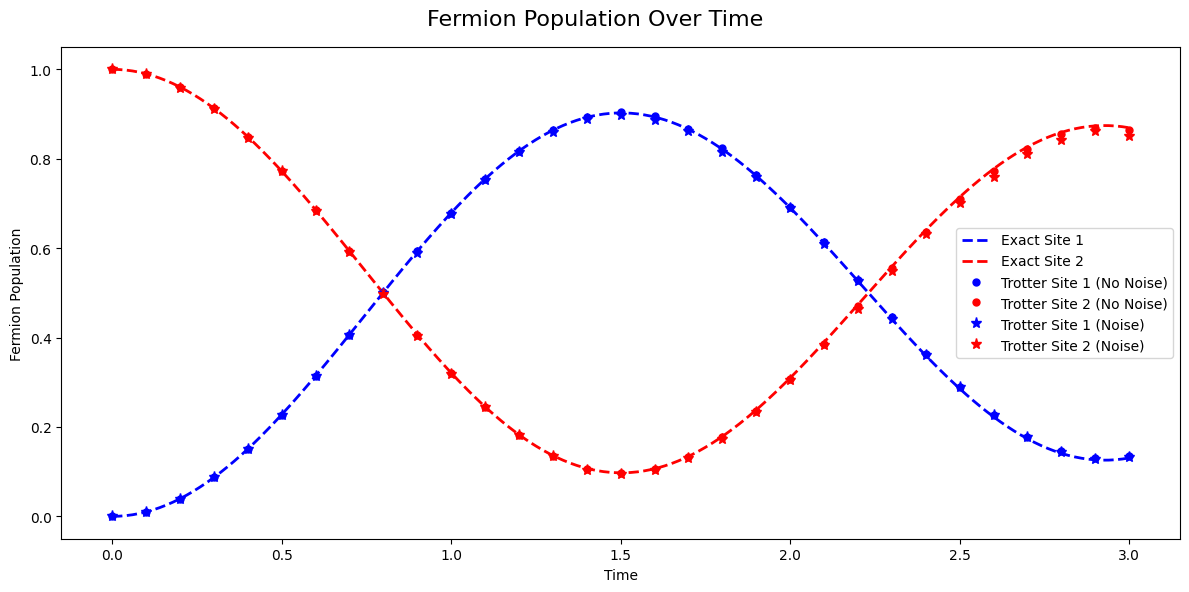

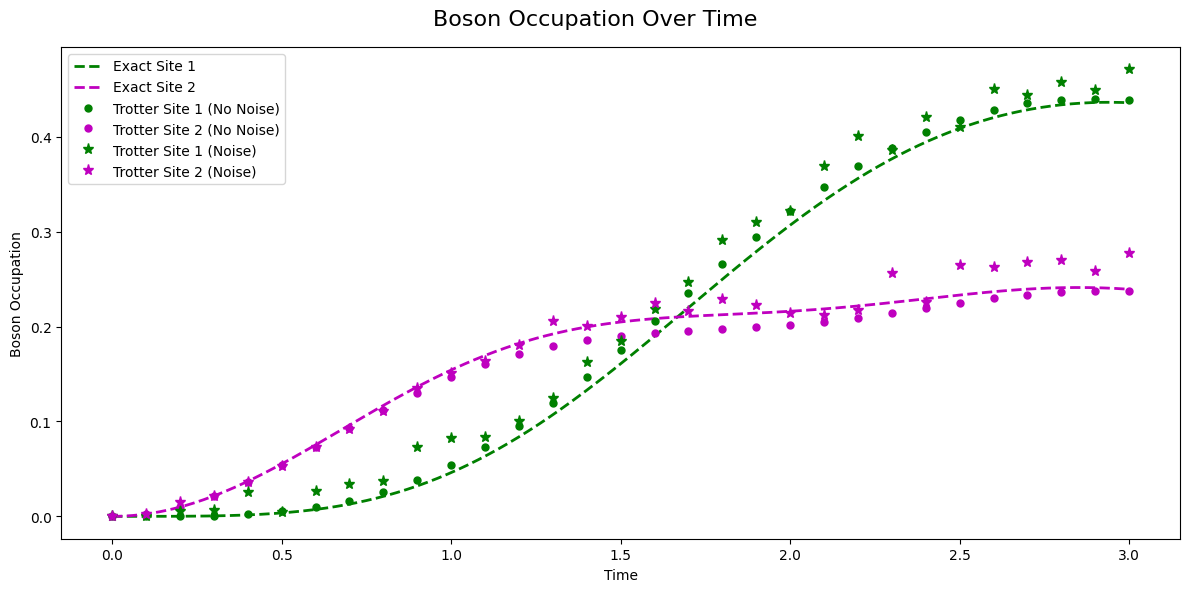

In [ ]:
# Extract exact simulation results (same for both, so irrelevant which we choose)
times_exact          = sim_data_no_noise["times_exact"]
fermion_pop1_exact   = sim_data_no_noise["fermion_pop1_exact"]
fermion_pop2_exact   = sim_data_no_noise["fermion_pop2_exact"]
boson_occ1_exact     = sim_data_no_noise["boson_occ1_exact"]
boson_occ2_exact     = sim_data_no_noise["boson_occ2_exact"]

# Noiseless Trotter
times_trotter        = sim_data_no_noise["times_trotter"]
trotter_fermion_pop1 = sim_data_no_noise["trotter_fermion_pop1"]
trotter_fermion_pop2 = sim_data_no_noise["trotter_fermion_pop2"]
trotter_boson_occ1   = sim_data_no_noise["trotter_boson_occ1"]
trotter_boson_occ2   = sim_data_no_noise["trotter_boson_occ2"]

# noisy Trotter and shot-by-shot data
times_trotter_noise        = sim_data_noise["times_trotter"]
noisy_trotter_fermion_pop1 = sim_data_noise["trotter_fermion_pop1"]
noisy_trotter_fermion_pop2 = sim_data_noise["trotter_fermion_pop2"]
noisy_trotter_boson_occ1   = sim_data_noise["trotter_boson_occ1"]
noisy_trotter_boson_occ2   = sim_data_noise["trotter_boson_occ2"]

# Calculate the standard deviations from the shot-by-shot data for error bars
shot_data = sim_data_noise["shot_data"]
fermion_pop1_noise_std = np.std(shot_data["fermion_pop1"], axis=1)
fermion_pop2_noise_std = np.std(shot_data["fermion_pop2"], axis=1)
boson_occ1_noise_std   = np.std(shot_data["boson_occ1"], axis=1)
boson_occ2_noise_std   = np.std(shot_data["boson_occ2"], axis=1)

# # Compute asymmetric error bars for fermion populations (bounded between 0 and 1)
# fermion_pop1_lower = np.where(noisy_trotter_fermion_pop1 - fermion_pop1_noise_std < 0,
#                               noisy_trotter_fermion_pop1,
#                               fermion_pop1_noise_std)
# fermion_pop1_upper = np.where(noisy_trotter_fermion_pop1 + fermion_pop1_noise_std > 1,
#                               1 - noisy_trotter_fermion_pop1,
#                               fermion_pop1_noise_std)

# fermion_pop2_lower = np.where(noisy_trotter_fermion_pop2 - fermion_pop2_noise_std < 0,
#                               noisy_trotter_fermion_pop2,
#                               fermion_pop2_noise_std)
# fermion_pop2_upper = np.where(noisy_trotter_fermion_pop2 + fermion_pop2_noise_std > 1,
#                               1 - noisy_trotter_fermion_pop2,
#                               fermion_pop2_noise_std)

# # Compute asymmetric error bars for boson occupations (bounded below by 0)
# boson_occ1_lower = np.where(noisy_trotter_boson_occ1 - boson_occ1_noise_std < 0,
#                             noisy_trotter_boson_occ1,
#                             boson_occ1_noise_std)
# boson_occ1_upper = boson_occ1_noise_std 

# boson_occ2_lower = np.where(noisy_trotter_boson_occ2 - boson_occ2_noise_std < 0,
#                             noisy_trotter_boson_occ2,
#                             boson_occ2_noise_std)
# boson_occ2_upper = boson_occ2_noise_std  

# Plot Fermion Populations
plt.figure(figsize=(12, 6))
plt.suptitle("Fermion Population Over Time", fontsize=16)
plt.plot(times_exact, fermion_pop1_exact, 'b--', label="Exact Site 1", linewidth=2)
plt.plot(times_exact, fermion_pop2_exact, 'r--', label="Exact Site 2", linewidth=2)
plt.plot(times_trotter, trotter_fermion_pop1, 'bo', label="Trotter Site 1 (No Noise)", markersize=5)
plt.plot(times_trotter, trotter_fermion_pop2, 'ro', label="Trotter Site 2 (No Noise)", markersize=5)
plt.plot(times_trotter_noise, noisy_trotter_fermion_pop1, 'b*', label="Trotter Site 1 (Noise)", markersize=8)
plt.plot(times_trotter_noise, noisy_trotter_fermion_pop2, 'r*', label="Trotter Site 2 (Noise)", markersize=8)
# plt.errorbar(times_trotter_noise, noisy_trotter_fermion_pop1,
#              yerr=[fermion_pop1_lower, fermion_pop1_upper],
#              fmt='b*', label="Trotter Site 1 (Noise)", markersize=8, capsize=3)
# plt.errorbar(times_trotter_noise, noisy_trotter_fermion_pop2,
#              yerr=[fermion_pop2_lower, fermion_pop2_upper],
#              fmt='r*', label="Trotter Site 2 (Noise)", markersize=8, capsize=3)
plt.xlabel("Time")
plt.ylabel("Fermion Population")
plt.legend()
plt.tight_layout()
plt.show()

# Plot Boson Occupations
plt.figure(figsize=(12, 6))
plt.suptitle("Boson Occupation Over Time", fontsize=16)
plt.plot(times_exact, boson_occ1_exact, 'g--', label="Exact Site 1", linewidth=2)
plt.plot(times_exact, boson_occ2_exact, 'm--', label="Exact Site 2", linewidth=2)
plt.plot(times_trotter, trotter_boson_occ1, 'go', label="Trotter Site 1 (No Noise)", markersize=5)
plt.plot(times_trotter, trotter_boson_occ2, 'mo', label="Trotter Site 2 (No Noise)", markersize=5)
plt.plot(times_trotter_noise, noisy_trotter_boson_occ1, 'g*', label="Trotter Site 1 (Noise)", markersize=8)
plt.plot(times_trotter_noise, noisy_trotter_boson_occ2, 'm*', label="Trotter Site 2 (Noise)", markersize=8)
# plt.errorbar(times_trotter_noise, noisy_trotter_boson_occ1,
#              yerr=[boson_occ1_lower, boson_occ1_upper],
#              fmt='g*', label="Trotter Site 1 (Noise)", markersize=8, capsize=3)
# plt.errorbar(times_trotter_noise, noisy_trotter_boson_occ2,
#              yerr=[boson_occ2_lower, boson_occ2_upper],
#              fmt='m*', label="Trotter Site 2 (Noise)", markersize=8, capsize=3)
plt.xlabel("Time")
plt.ylabel("Boson Occupation")
plt.legend()
plt.tight_layout()
plt.show()


### Number of Trotter Steps


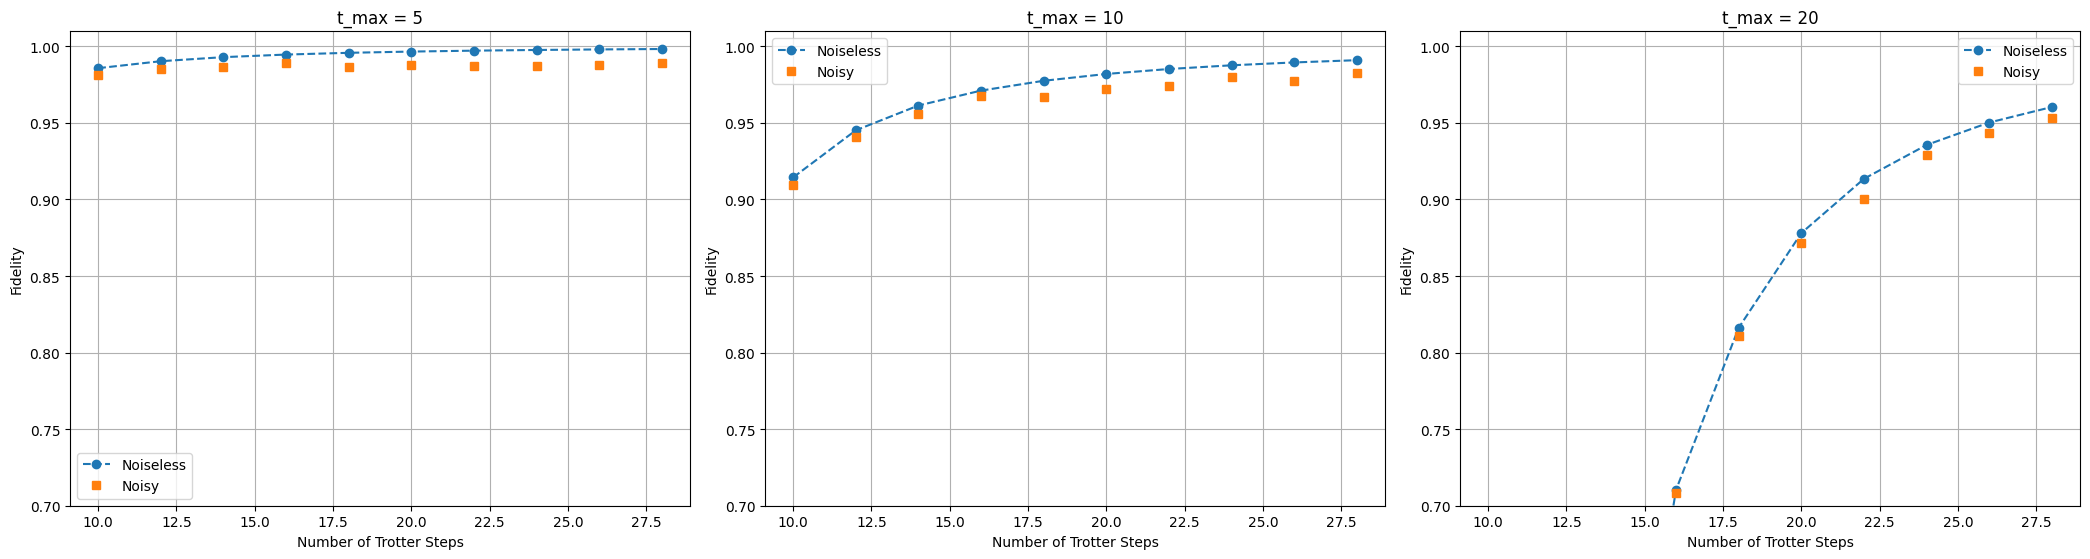

In [ ]:
import warnings
from scipy.sparse import SparseEfficiencyWarning
warnings.filterwarnings("ignore", category=SparseEfficiencyWarning)
warnings.filterwarnings(
    "ignore",
    message="PhotonLossNoisePass ignores instructions without duration, you may need to schedule circuit in advance",
    category=UserWarning
)

t_max_values = [5, 10, 20]
v = 1.0
omega = 1.0
g = 0.5
num_qubits_per_qumode = 3
N_b = 2**num_qubits_per_qumode 
shots = 1028
fermion_init = [0, 1, 0, 0] # Fermion initial state
steps_list = np.arange(10, 30, 2) # Trotter step counts 

fig, axs = plt.subplots(1, 3, figsize=(21, 6))
for idx, t_max in enumerate(t_max_values):
    # Get exact final state
    exact_result = exact_qutip_holstein_sim(v=v, omega=omega, g=g, N_b=N_b,
                                             t_max=t_max, num_steps=101,
                                             fermion_init=fermion_init)
    psi_exact = exact_result.states[-1]

    fid_list = []              # fidelity for noiseless simulation
    fid_noise_avg_list = []    # average fidelity for noisy simulation
    # lower_err_list = []        # lower error bar (avg - min)
    # upper_err_list = []        # upper error bar (max - avg)
    
    for steps in steps_list:
        dt_trotter = t_max / steps  # time step 
        
        # Noiseless trotter
        psi_trotter, _ = simulate_holstein_model(dt=dt_trotter, num_trotter=steps,
                                                  v=v, omega=omega, g=g,
                                                  fermion_init=fermion_init,
                                                  num_qubits_per_qumode=num_qubits_per_qumode,
                                                  noise=False)
        fid = qt.fidelity(psi_exact, psi_trotter)
        fid_list.append(fid)
        
        # Noisy tritter returns a list of statevectors
        psi_trotter_noisy_list, _ = simulate_holstein_model(dt=dt_trotter, num_trotter=steps,
                                                             v=v, omega=omega, g=g,
                                                             fermion_init=fermion_init,
                                                             num_qubits_per_qumode=num_qubits_per_qumode,
                                                             noise=True, shots=shots)
        shot_fids = []
        for state in psi_trotter_noisy_list:
            shot_fid = qt.fidelity(psi_exact, state)
            shot_fids.append(shot_fid)
        
        avg_fid = np.mean(shot_fids)
        fid_noise_avg_list.append(avg_fid)
        # # Compute asymmetric error bars:
        # lower_err = avg_fid - min(shot_fids)
        # upper_err = max(shot_fids) - avg_fid
        # lower_err_list.append(lower_err)
        # upper_err_list.append(upper_err)

    # Plot 
    ax = axs[idx]
    ax.plot(steps_list, fid_list, linestyle='--', marker='o', label="Noiseless")
    ax.plot(steps_list, fid_noise_avg_list, 's', label="Noisy")
    # ax.errorbar(steps_list, fid_noise_avg_list, yerr=[lower_err_list, upper_err_list],
    #             fmt='s', capsize=5, label="Noisy")
    
    ax.set_xlabel("Number of Trotter Steps")
    ax.set_ylabel("Fidelity")
    ax.set_title(f"t_max = {t_max}")
    ax.grid(True)
    ax.set_ylim(0.7, 1.01)
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Hilbert Space Truncation


### Compiling into Instruction Set Architecture
Thus far we have just treated all operators/gates equally. However, we need to consider compiling the hybrid oscillator-qubit gates into "native" or fundamental gates on the hardware.

**fSim gate**:
1) All-all qubit connectivity: Below we see this costs an upper bound of 8 non clifford `rz` rotations, although it averages $\approx 5$ `rz` rotations. It would be useful to investigate a proper (analytical) decomposition of the `fSim` gate.

In [ ]:
# Define the target basis and theta values
target_basis = ['rz', 'sx', 'cx']
theta_values = np.linspace(0, 2*np.pi, 100)

non_pi_over2_counts = []
cx_counts = []

for theta in theta_values:
    qc = QuantumCircuit(2)
    qc.append(hopping_term(theta), [0, 1])
    decomposed_qc = transpile(qc, basis_gates=target_basis)  # Decompose into target basis.

    # Count the number of non-Clifford Rz gates and CNOT gates.
    rz_count = 0
    cx_count = 0
    for inst in decomposed_qc.data:
        if inst.operation.name == "rz":
            angle_param = inst.operation.params[0]
            # Check if the angle is not a multiple of pi/2.
            if not np.isclose(angle_param % (np.pi/2), 0, atol=1e-6):
                rz_count += 1
        if inst.operation.name == "cx":
            cx_count += 1
    non_pi_over2_counts.append(rz_count)
    cx_counts.append(cx_count)

avg_rz = np.mean(non_pi_over2_counts)
max_rz = np.max(non_pi_over2_counts)
avg_cx = np.mean(cx_counts)
max_cx = np.max(cx_counts)

print(f"Average number of non-Clifford Rz gates: {avg_rz:.2f}")
print(f"Maximum number of non-Clifford Rz gates: {max_rz}")
print(f"Average number of CNOT gates: {avg_cx:.2f}")
print(f"Maximum number of CNOT gates: {max_cx}")


Average number of non-Clifford Rz gates: 4.58
Maximum number of non-Clifford Rz gates: 8
Average number of CNOT gates: 2.00
Maximum number of CNOT gates: 2


2. Oscillator Mediated:
On some architectures we may consider, multi-qubit gates may need to be oscillator mediated. First note that the `fSim` gate will require 2 CNOT gates (unless $\theta = 2n\pi$). From Sec V.C.2 [here](https://arxiv.org/pdf/2407.10381), we note that a CNOT requires 4 beamsplitters and 4 controlled displacements. We assume these are native gates in this architecture, thus we require 4 oscillator-oscillator gates, 4 qubit-oscillator gates, and 8 non-clifford qubit gates.


Thus, assuming we have native access to the following gates:
- $\text{CD}(\beta)$: controlled displacement,
- $\text{R}_\phi(\theta)$: qubit rotation,
- $\text{BS}(\theta,\phi)$: beamsplitter,
- $\text{D}(\alpha)$: displacement, and
- $\text{R}(\theta)$: oscillator phase rotation,

for $N>2$ sites the total operation count is given by (on average)
$$
N\Big(5\,\text{CD}(\beta) + 4\,\text{BS}(\theta,\phi) + \text{D}(\alpha) + \text{R}(\theta) + 5\,\text{non-Clifford}\Big),
$$
or $16N$ total operations if two qubit gates need to be oscillator mediated. If we assume qubits have all to all connectiviity, this becomes (on average)
$$
N\Big(5\,\text{CD}(\beta) + \text{D}(\alpha) + \text{R}(\theta) + 5\,\text{non-Clifford}\Big),
$$
or $11N$ total operations.